# Visualizing Embeddings with UMAP 

This is a demo to see the embeddings generated by different models and how they look like.

In [1]:
import numpy as np
import torch as t
from transformers import AutoModel, AutoTokenizer, pipeline
from datasets import load_dataset
from sentence_transformers import SentenceTransformer

import matplotlib.pyplot as plt
import seaborn as sns
import umap
import umap.plot

import requests
import os

device = "mps" if t.backends.mps.is_available() else "cpu"
t.mps.empty_cache()

/Users/kj3moraes/Library/Caches/pypoetry/virtualenvs/reader-qnfOF5hD-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data

We will be using the news dataset (okite97/news-data) from HuggingFace.


In [2]:
dataset = load_dataset("okite97/news-data", split="train")
for data in dataset:
    print(f"Category: {data['Category']}")
    print("---------------------------------------")
    print(f"Title: {data['Title']}")
    print(f"Exceprt: {data['Excerpt']}")
    print("---------------------------------------\n\n")

Category: sports
---------------------------------------
Title: Uefa Opens Proceedings against Barcelona, Juventus and Real Madrid Over European Super League Plan
Exceprt: Uefa has opened disciplinary proceedings against Barcelona, Juventus and Real Madrid over their involvement in the proposed European Super League.
---------------------------------------


Category: business
---------------------------------------
Title: Amazon Blames Inflation as It Increases Cost of Prime in Europe
Exceprt: The increases are steeper than the 17 percent jump in the Prime membership price that came into effect for new
---------------------------------------


Category: politics
---------------------------------------
Title: Nigeria’s Parliament Passes Amended Electoral Bill
Exceprt: Nigeria's Senate on Tuesday passed the harmonised Clause 84 of the 2010 Electoral Act (Amendment) Bill 2022, which allows political
---------------------------------------


Category: health
------------------------------

In [3]:
categories = list(set([data["Category"] for data in dataset]))
print(categories)
print(sns.color_palette("Blues").as_hex()[1])
COLOR_KEY = {}
COLOR_KEY[categories[0]] = sns.color_palette("Blues").as_hex()[1]
COLOR_KEY[categories[1]] = sns.color_palette("Purples").as_hex()[1]
COLOR_KEY[categories[2]] = sns.color_palette("YlOrRd").as_hex()[1]
COLOR_KEY[categories[3]] = sns.color_palette("light:teal").as_hex()[1]
COLOR_KEY[categories[4]] = sns.color_palette("light:#660033").as_hex()[1]
COLOR_KEY[categories[5]] = sns.color_palette("YlGn").as_hex()[1]

['entertainment', 'business', 'sports', 'politics', 'tech', 'health']
#bad6eb


## Models 

I will be using mutliple models from HuggingFace to compare their embedding graphs. The list is 
1. all-MiniLM-L6-v2
2. all-mpnet-base-v2
3. word2vec

In [36]:
minilm = SentenceTransformer("all-MiniLM-L6-v2").to(device)
mpnet = SentenceTransformer("all-mpnet-base-v2").to(device)

In [5]:
%%time 
minilm_embeddings = minilm.encode(dataset["Title"])
minilm_mapper = umap.UMAP(
    metric='cosine',
).fit(minilm_embeddings)

/Users/kj3moraes/Library/Caches/pypoetry/virtualenvs/reader-qnfOF5hD-py3.11/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


CPU times: user 14.2 s, sys: 3.3 s, total: 17.5 s
Wall time: 15.5 s


<Axes: >

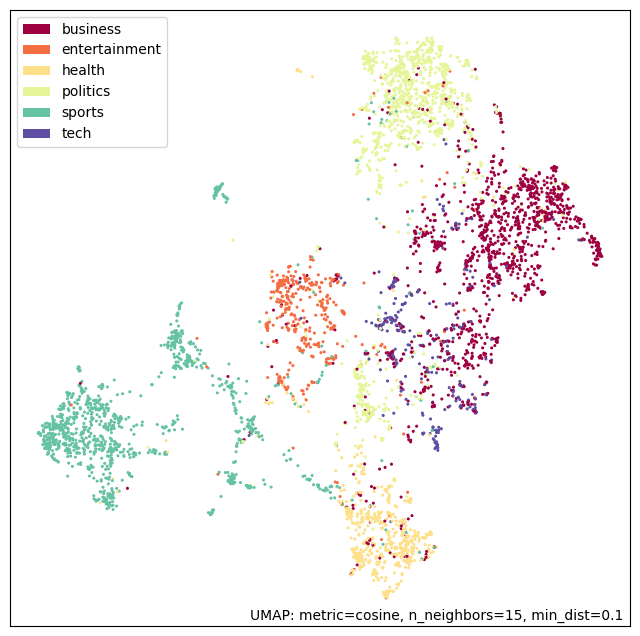

In [9]:
umap.plot.points(
    minilm_mapper,
    labels=np.array(dataset["Category"]),
)

In [29]:
%%time
mpnet_embeddings = mpnet.encode(dataset["Title"])

mpnet_mapper = umap.UMAP(
    metric='cosine',
).fit(mpnet_embeddings)

<class 'numpy.ndarray'>
CPU times: user 29 µs, sys: 9 µs, total: 38 µs
Wall time: 45.1 µs


<Axes: >

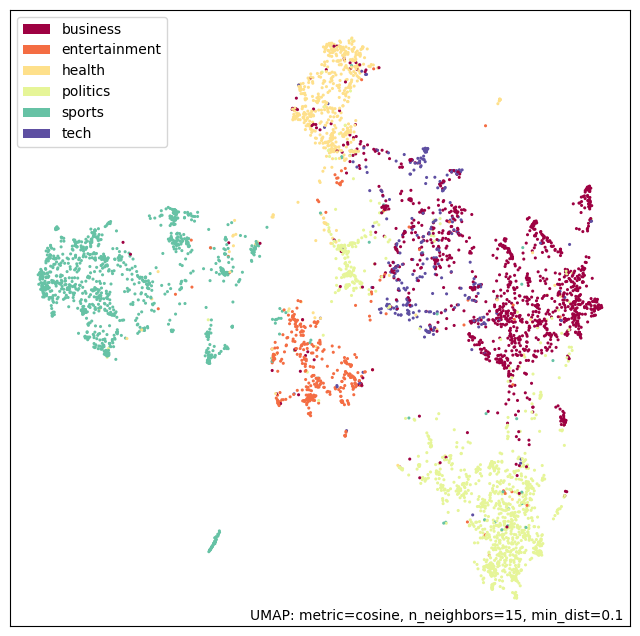

In [14]:
umap.plot.points(
    mpnet_mapper,
    labels=np.array(dataset["Category"]),
)

## Experimenting with different hyperparameters
 
Using just one of the embedding models (mpnet), we will try and explore what happens to the embeddings when you tune the hyperparameters of UMAP. The hyperparameters we will change are 
- n_neighbours
- min_dist

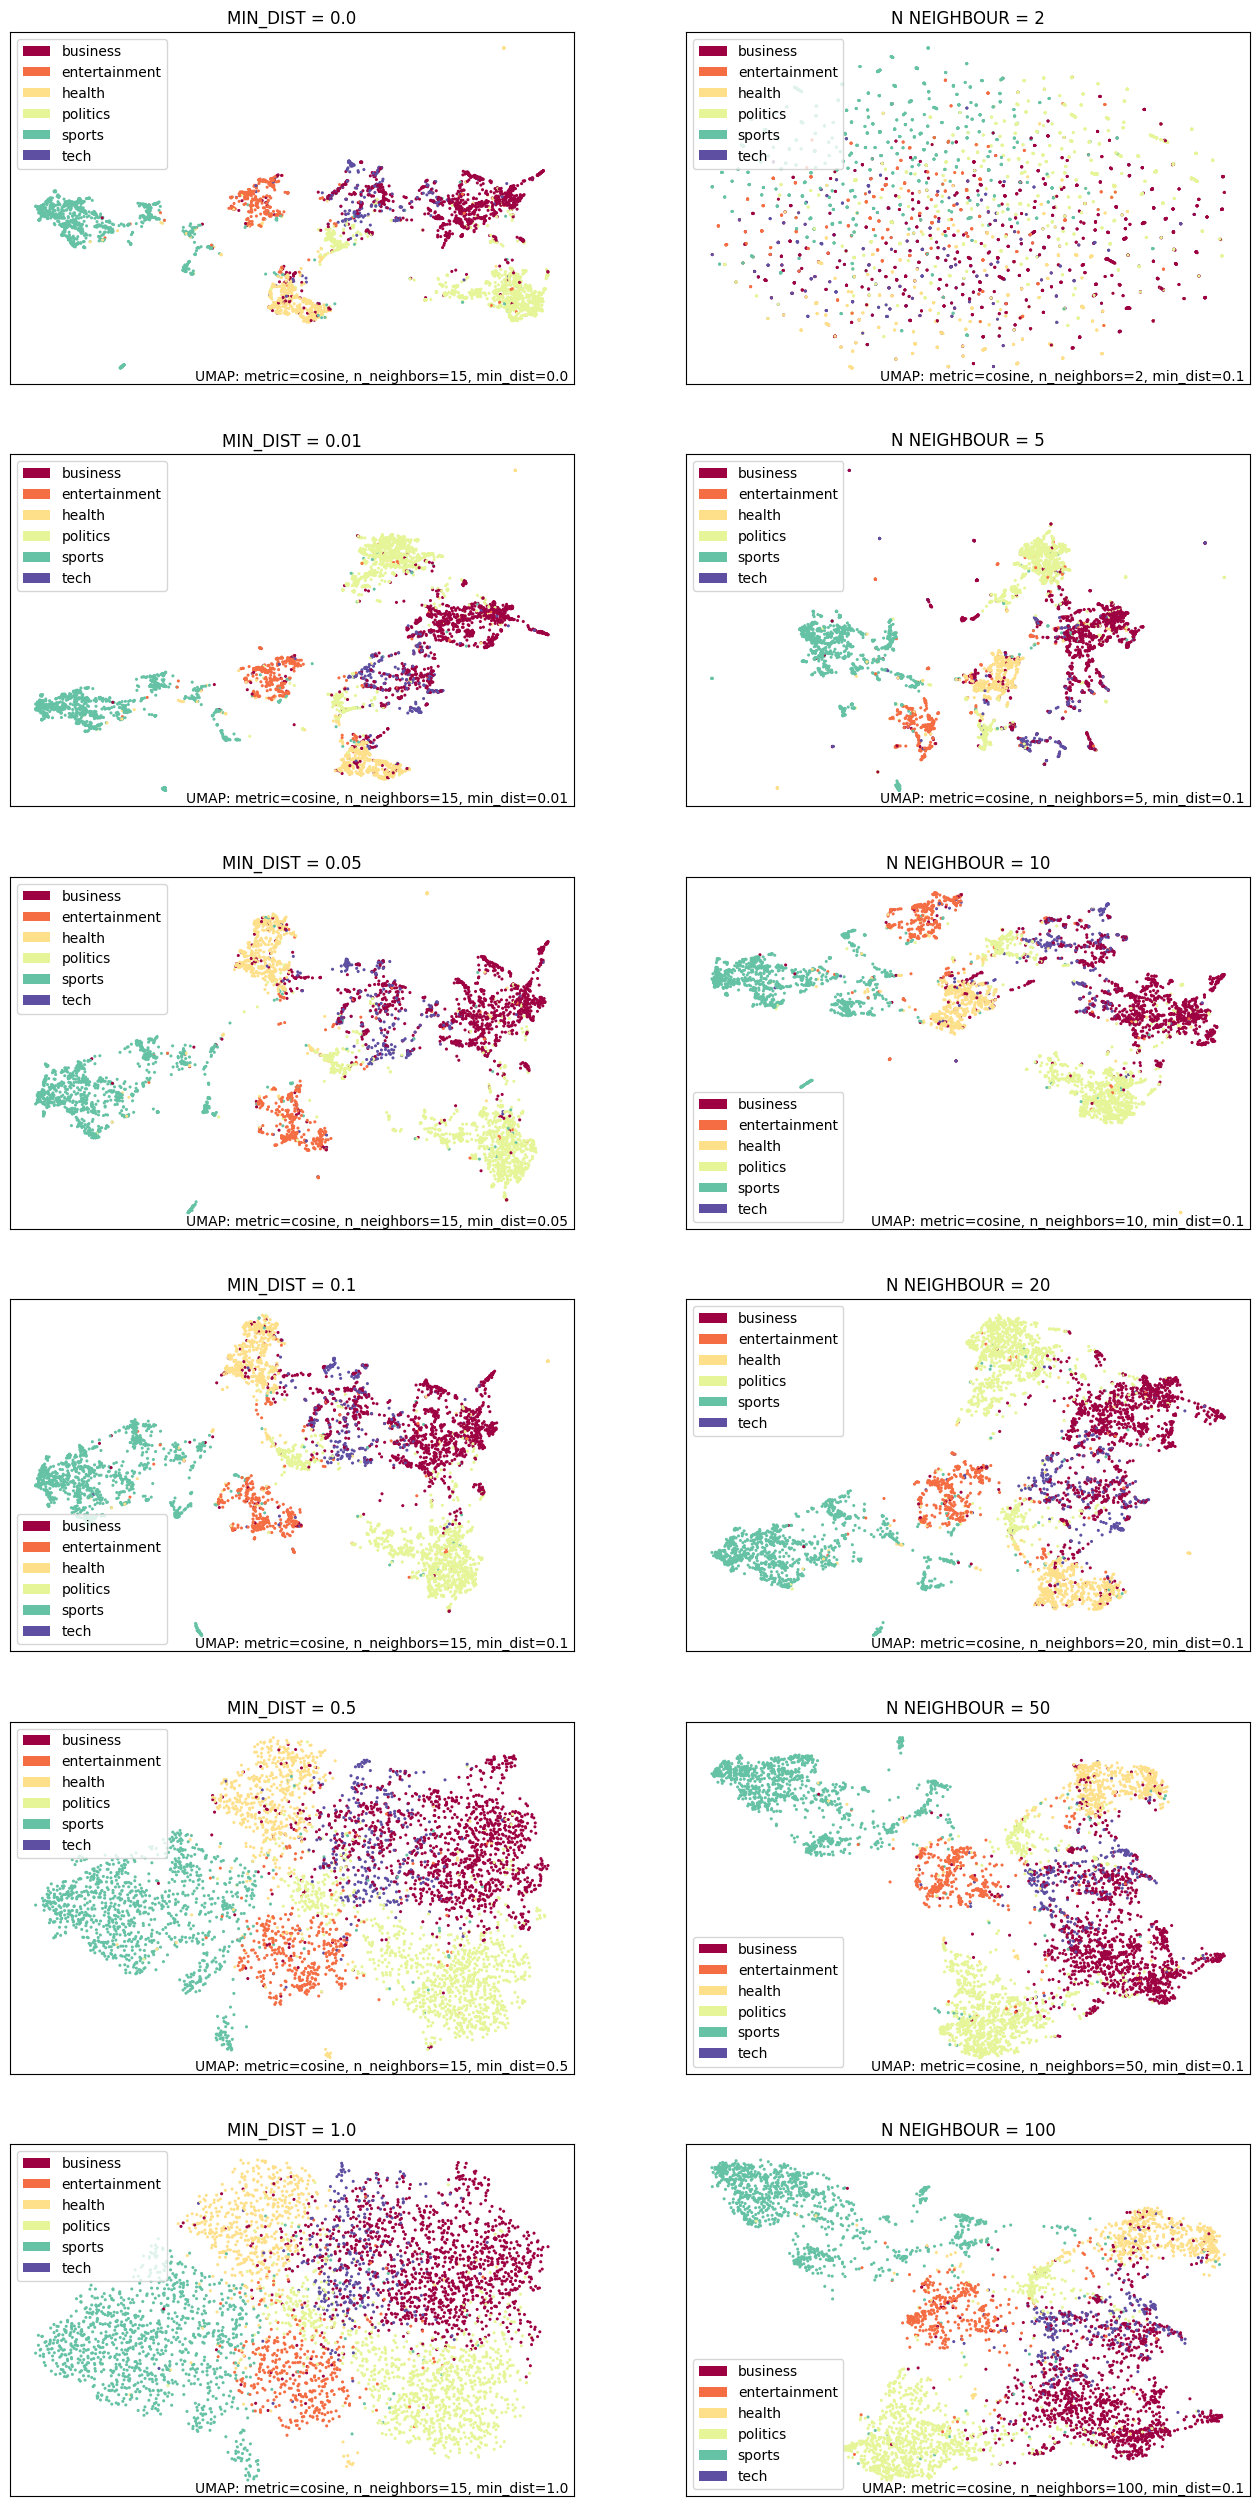

In [35]:
fig, axs = plt.subplots(6, 2, figsize=(16, 32))
DEFAULT_N_NEIGHBOURS = 15
DEFAULT_MIN_DIST = 0.1
n_neighbours = [2, 5, 10, 20, 50, 100]
min_dists = [0.0, 0.01, 0.05, 0.1, 0.5, 1.0]

for i in range(6):
    nn_fitter = umap.UMAP(
        metric='cosine',
        n_neighbors=n_neighbours[i],
        min_dist=DEFAULT_MIN_DIST
    ).fit(mpnet_embeddings)

    md_fitter = umap.UMAP(
        metric='cosine',
        n_neighbors=DEFAULT_N_NEIGHBOURS,
        min_dist=min_dists[i]
    ).fit(mpnet_embeddings)
     
    umap.plot.points(
        md_fitter,
        labels=np.array(dataset["Category"]),
        ax=axs[i, 0]
    )   
    axs[i, 0].set_title(f"MIN_DIST = {min_dists[i]}")

    umap.plot.points(
        nn_fitter,
        labels=np.array(dataset["Category"]),
        ax=axs[i, 1]
    )   
    axs[i, 1].set_title(f"N NEIGHBOUR = {n_neighbours[i]}")

## Embedding Models from HuggingFace

Now we will test out some of the embedding models from HuggingFace to see how well they perform in embeddings. 
1. intfloat/e5-mistral-7b-instruct
2. Salesforce/SFR-Embedding-Mistral
3. avsolatorio/GIST-small-Embedding-v0

In [9]:
def encode(model, tokenizer):
    def get_embedding(text: str):
        if text is None:
            return
        assert isinstance(text, str)
        encoded_input = tokenizer(text, return_tensors='pt')
        for k, v in encoded_input.items():
            encoded_input[k] = v.to(device)
        attention_mask = encoded_input["attention_mask"]
        model_output = model(**encoded_input)
        token_embeddings = model_output[0]  
        expanded_attention_mask = attention_mask.unsqueeze(-1).expand(token_embeddings.shape).float()
        sum_embeddings = (token_embeddings * expanded_attention_mask).sum(dim=1)
        sum_mask = t.clamp(expanded_attention_mask.sum(dim=1), min=1e-10)
        return sum_embeddings / sum_mask
    return get_embedding

In [ ]:
gist_t = AutoTokenizer.from_pretrained("avsolatorio/GIST-small-Embedding-v0")
gist_m = AutoModel.from_pretrained("avsolatorio/GIST-small-Embedding-v0").to(device)

gist_embeddings = list(map(encode(gist_m, gist_t), dataset["Title"]))
print(len(gist_embeddings))

In [ ]:
gist_mapper = umap.UMAP(
    metric='cosine',
    random_state=42
).fit(gist_embeddings)

In [ ]:
umap.plot.points(
    gist_mapper,
    labels=data["Category"]
)